In [6]:
from utils.binaries import *

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, t=None, version=None):
     
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC_bin_edges = np.array([4*k for k in range(100)] + [400 + 16*k for k in range(51)])
        case 3:
            ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
    ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])

    skip = 5
    _peak = np.argmax(counts[skip:100]) + skip
    _dip = np.argmax(np.diff(counts)) + 3
    start, stop = _dip + int(0.5 * (_peak - _dip)), _peak + int(0.5*(_peak - _dip))

    try:
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop],
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, ADC[_peak], counts[_peak]])

        file_loc = f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/{t}.png"

        if not os.path.isfile(file_loc):
            os.makedirs(f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/", exist_ok=True)
            fig = plt.figure()
            plt.plot(ADC, counts)
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height))
            plot.save(fig, f'DaqIntegrationTest/{version}/pmt{int(p)}/{t}.png')
            plt.close(fig)


        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError
        if mip.n > 300: raise ValueError
    except:
        return np.nan, np.nan

    return mip.n, mip.std_dev

thresholds = [20, 25, 30, 35, 40]
filter = lambda x, i: x[i::4]

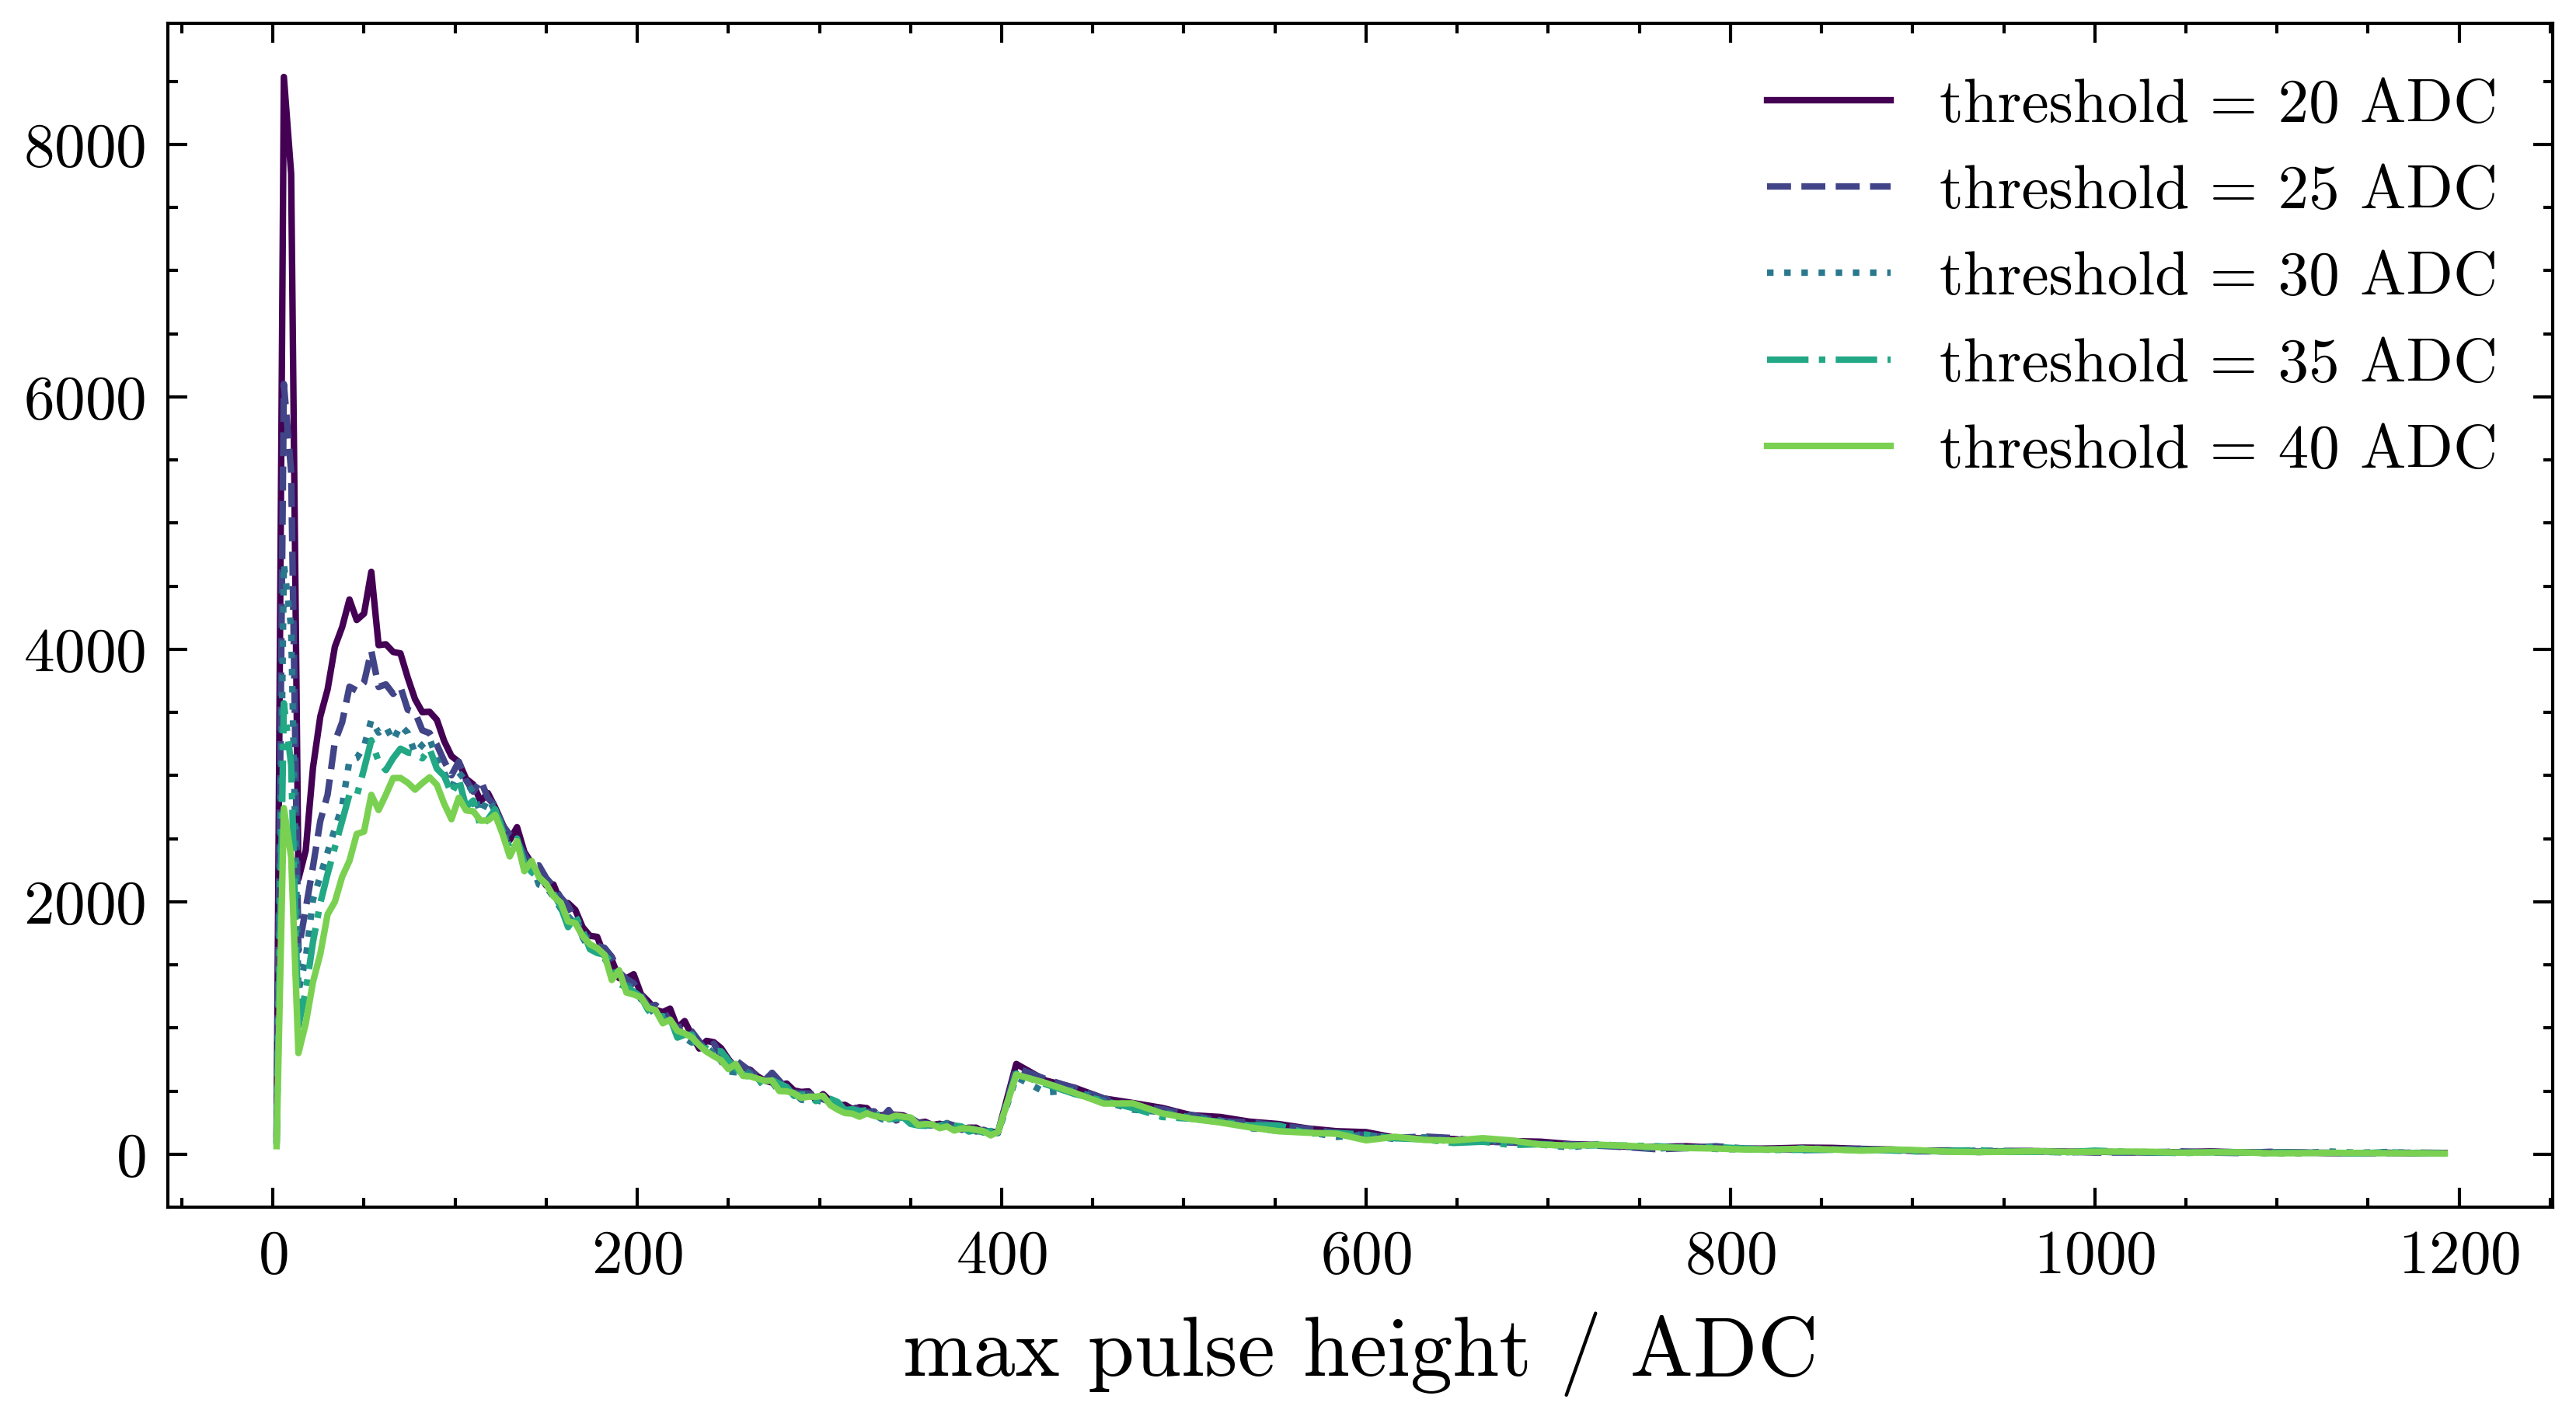

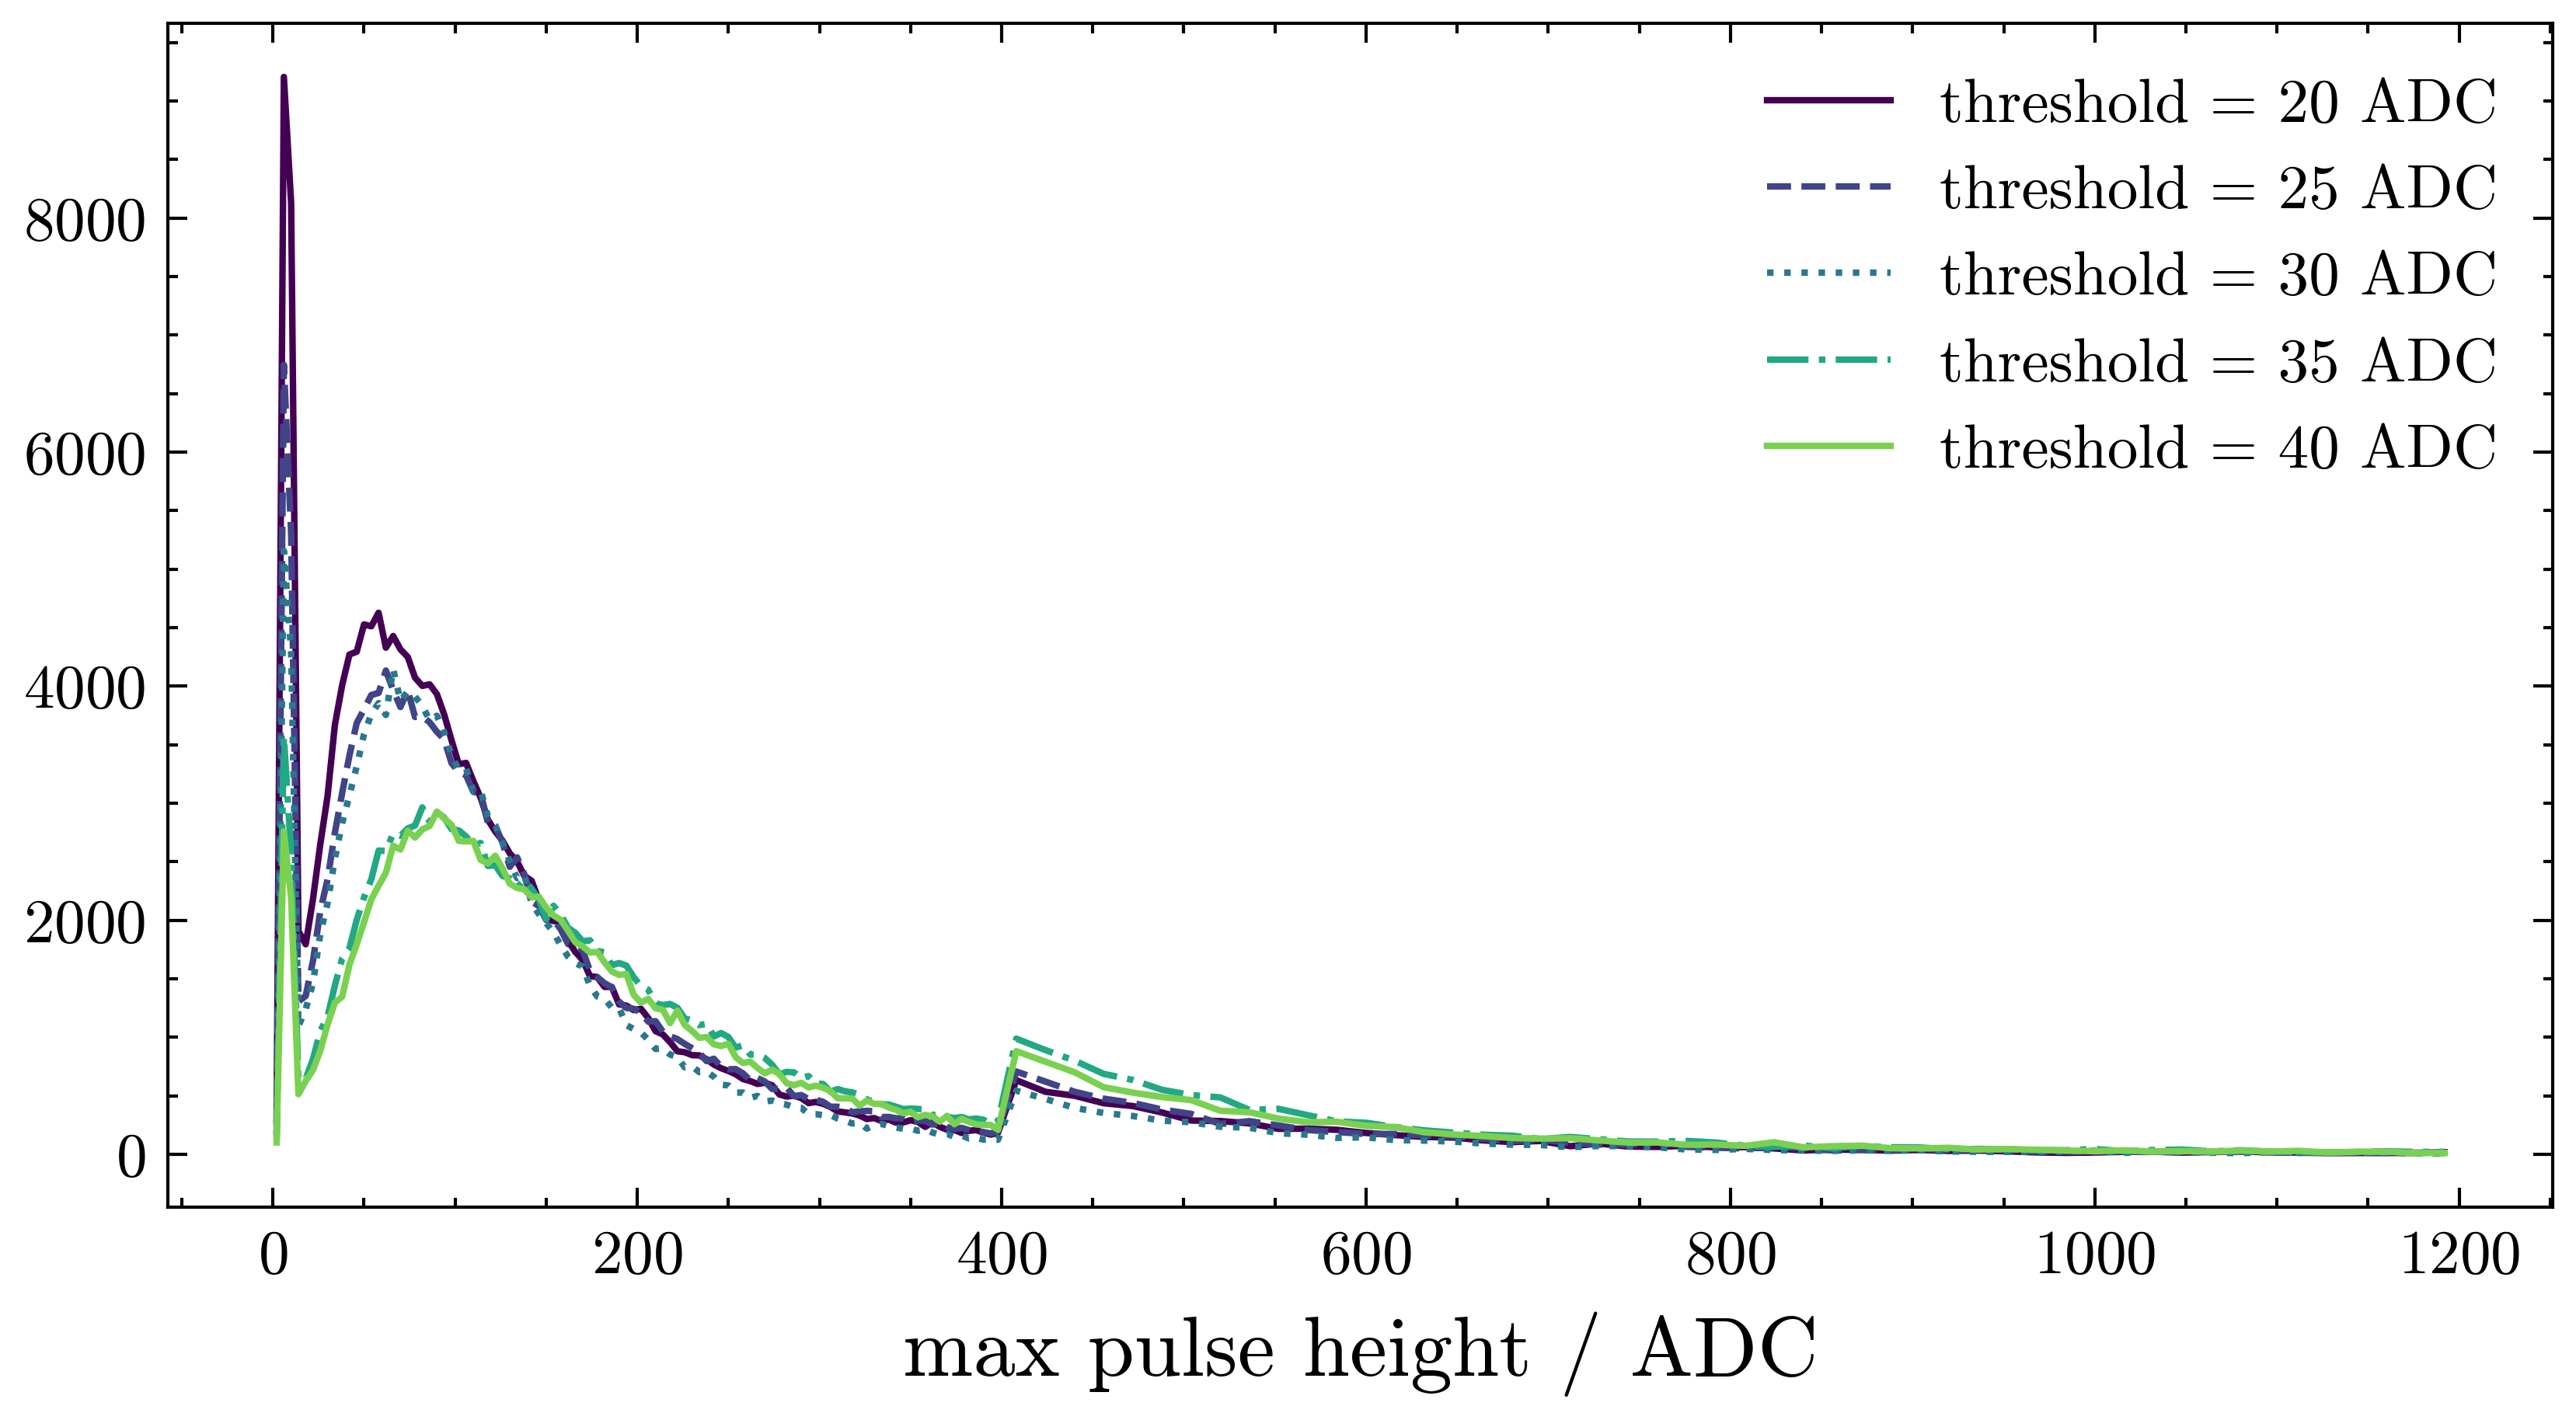

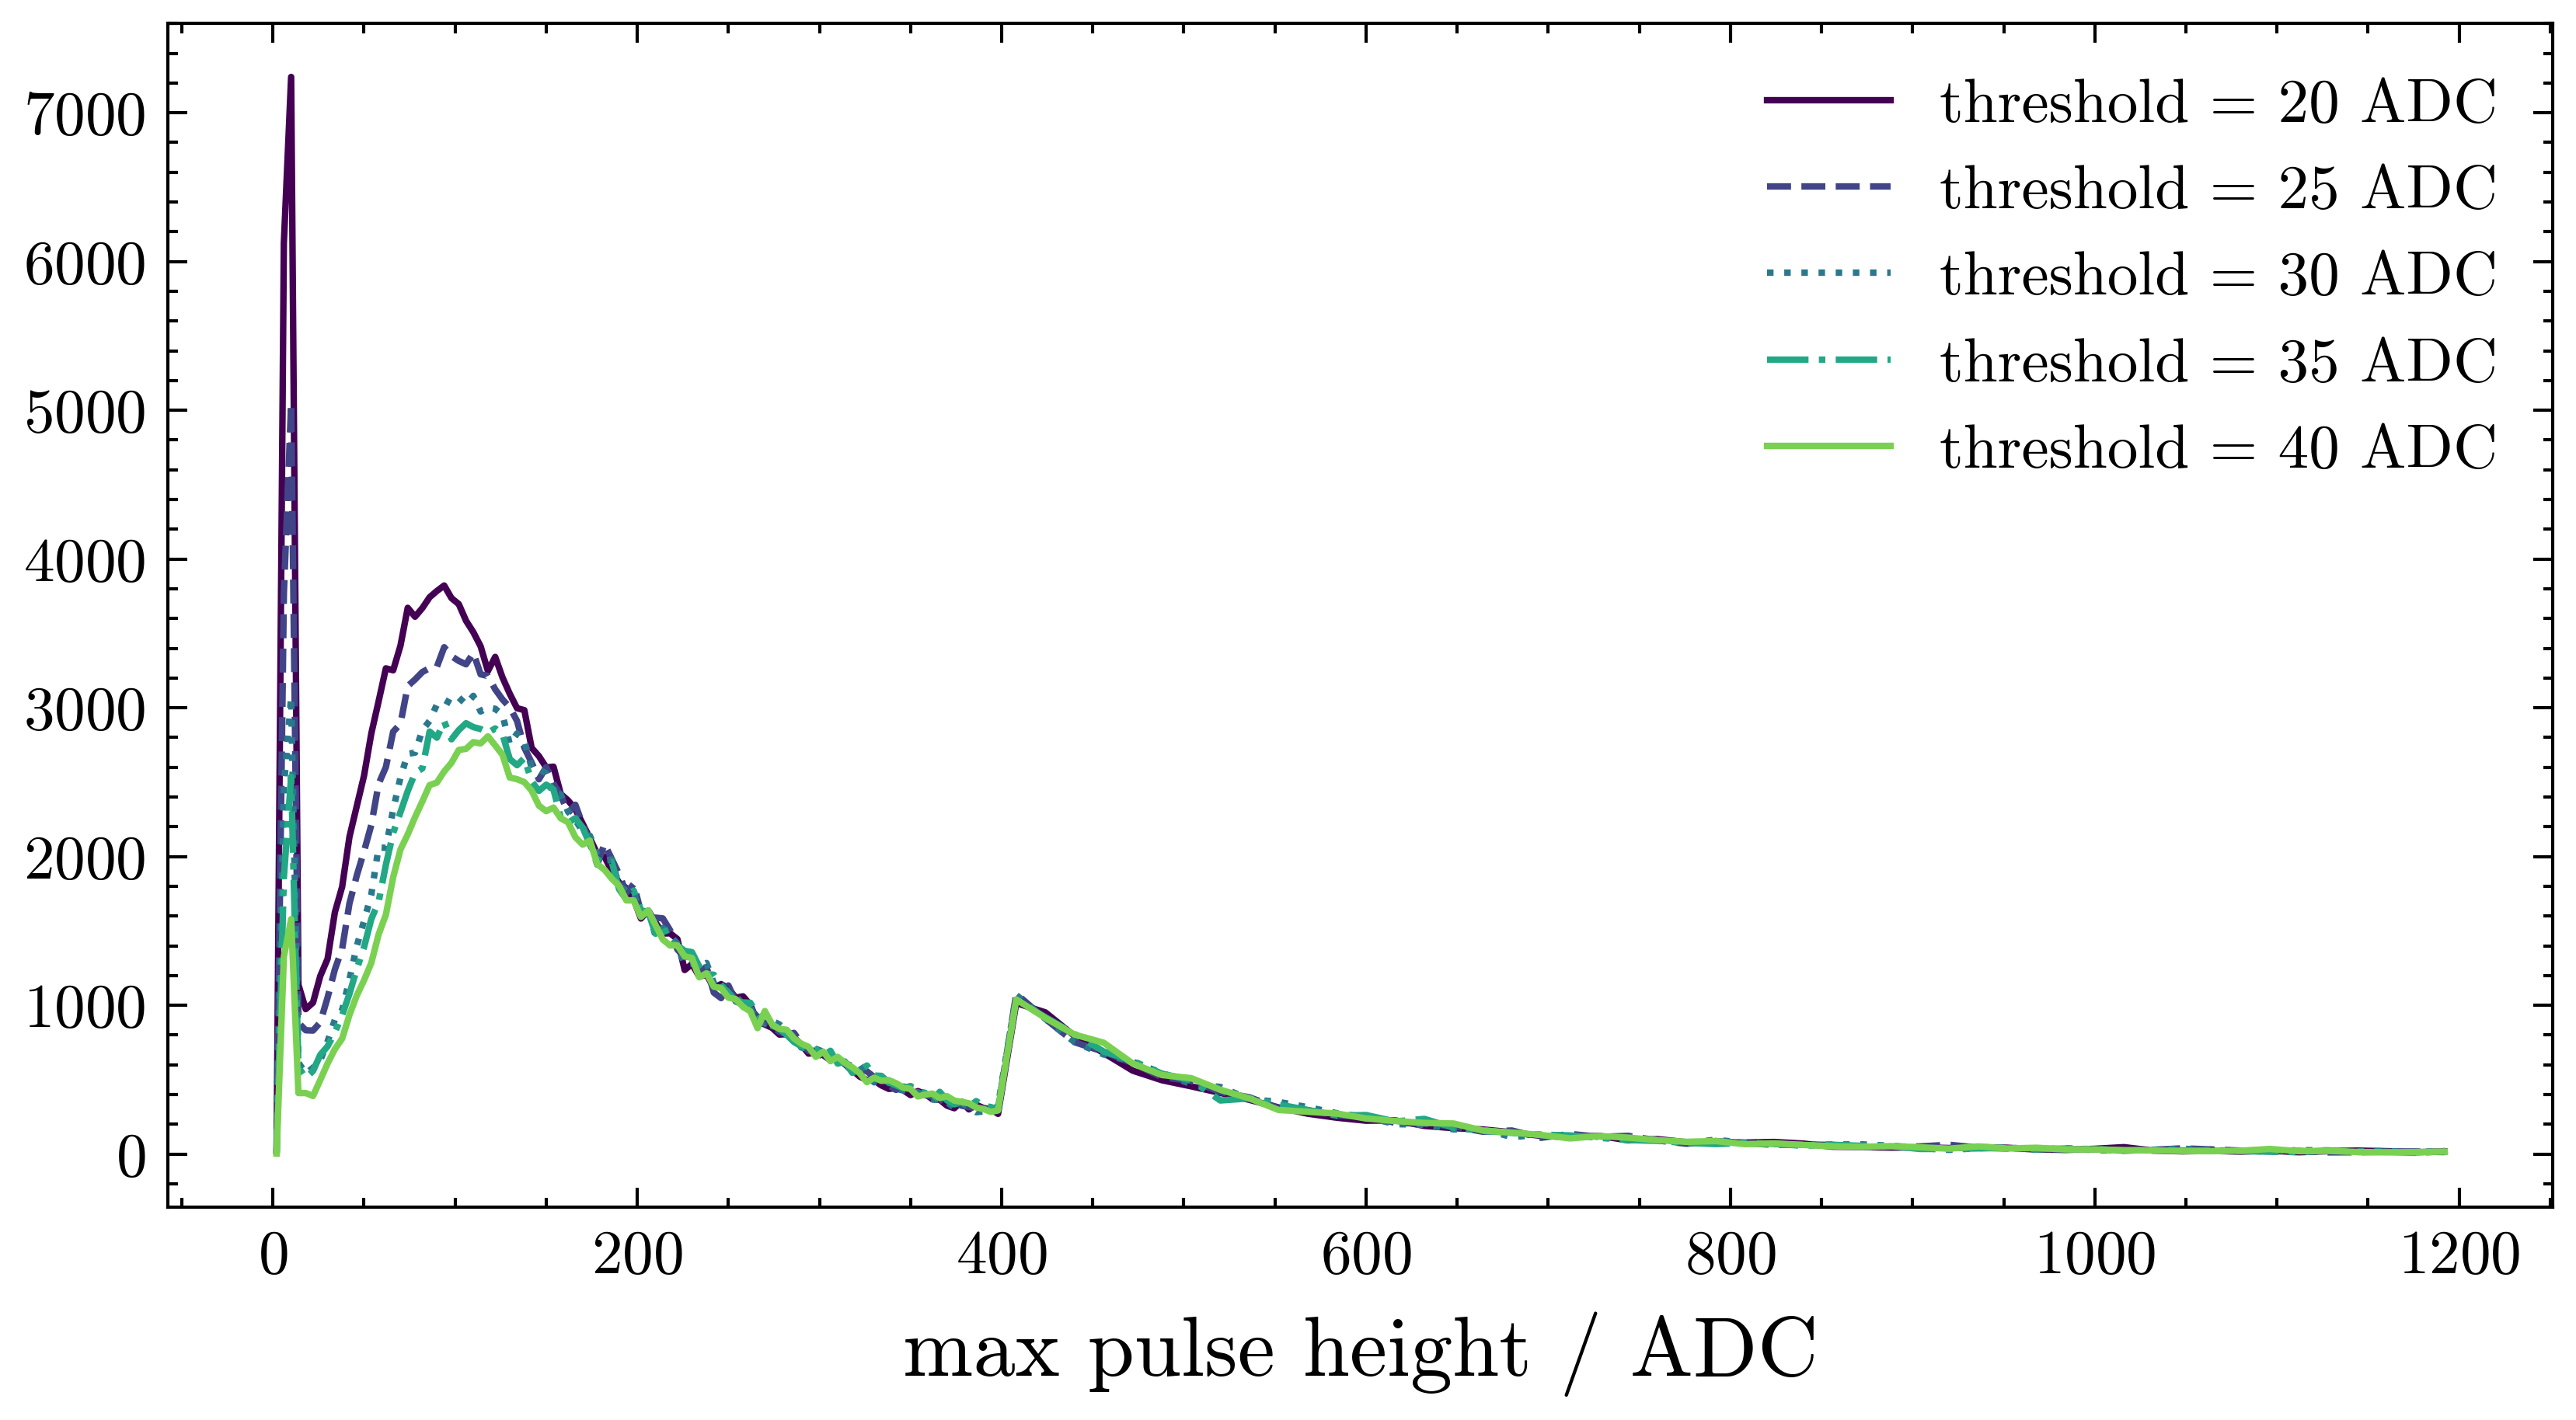

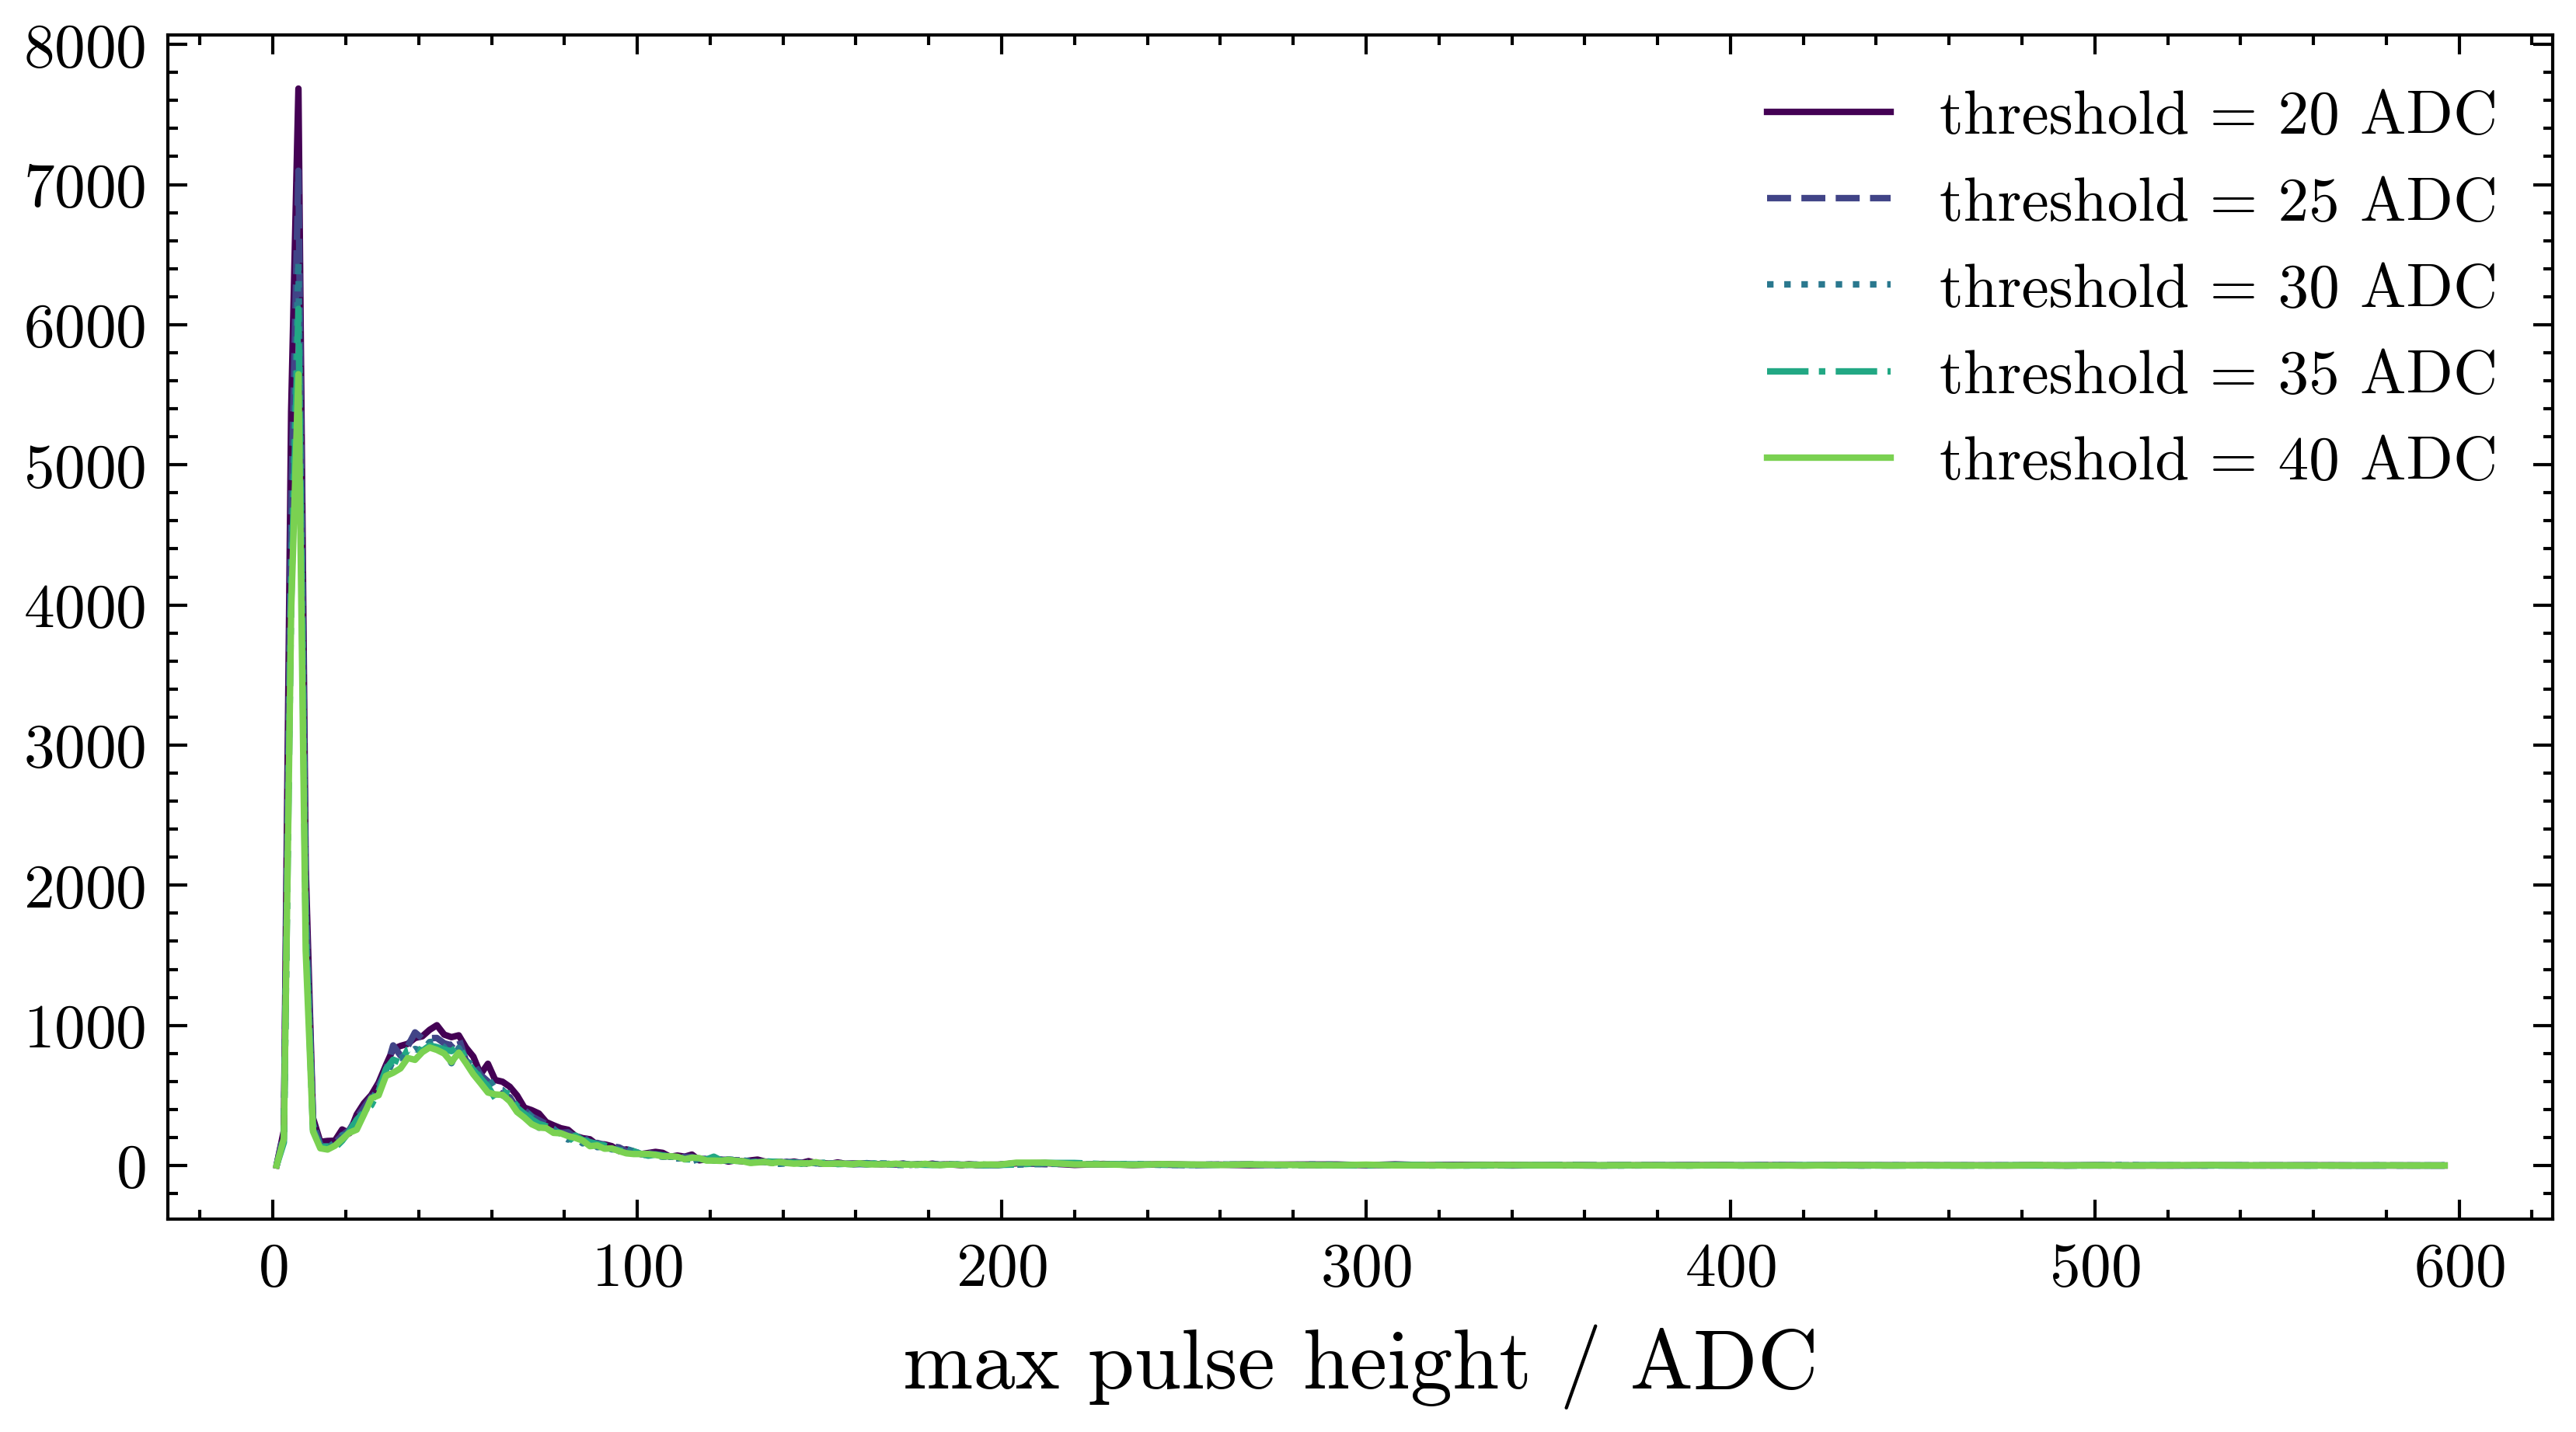

In [9]:
from utils.plotting import *
from utils import CONSTANTS

data = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v32/peak.txt')
data = np.split(data, 5)

axes = [plt.subplots()[1] for _ in range(4)]
colors = plot.gradient(plt.cm.viridis, 5)

for th, h, c in zip(thresholds, data, colors):
    for i, (pmt, ax) in enumerate(zip(h, axes)):
        bins = CONSTANTS.UUB_SSD_BIN_CENTERS if i == 3 else CONSTANTS.UUB_WCD_BIN_CENTERS
        ax.plot(bins, pmt[4:], c=c, label=f'threshold = {th} ADC')


for ax in axes:
    ax.legend()
    ax.set_xlabel('max pulse height / ADC')
    

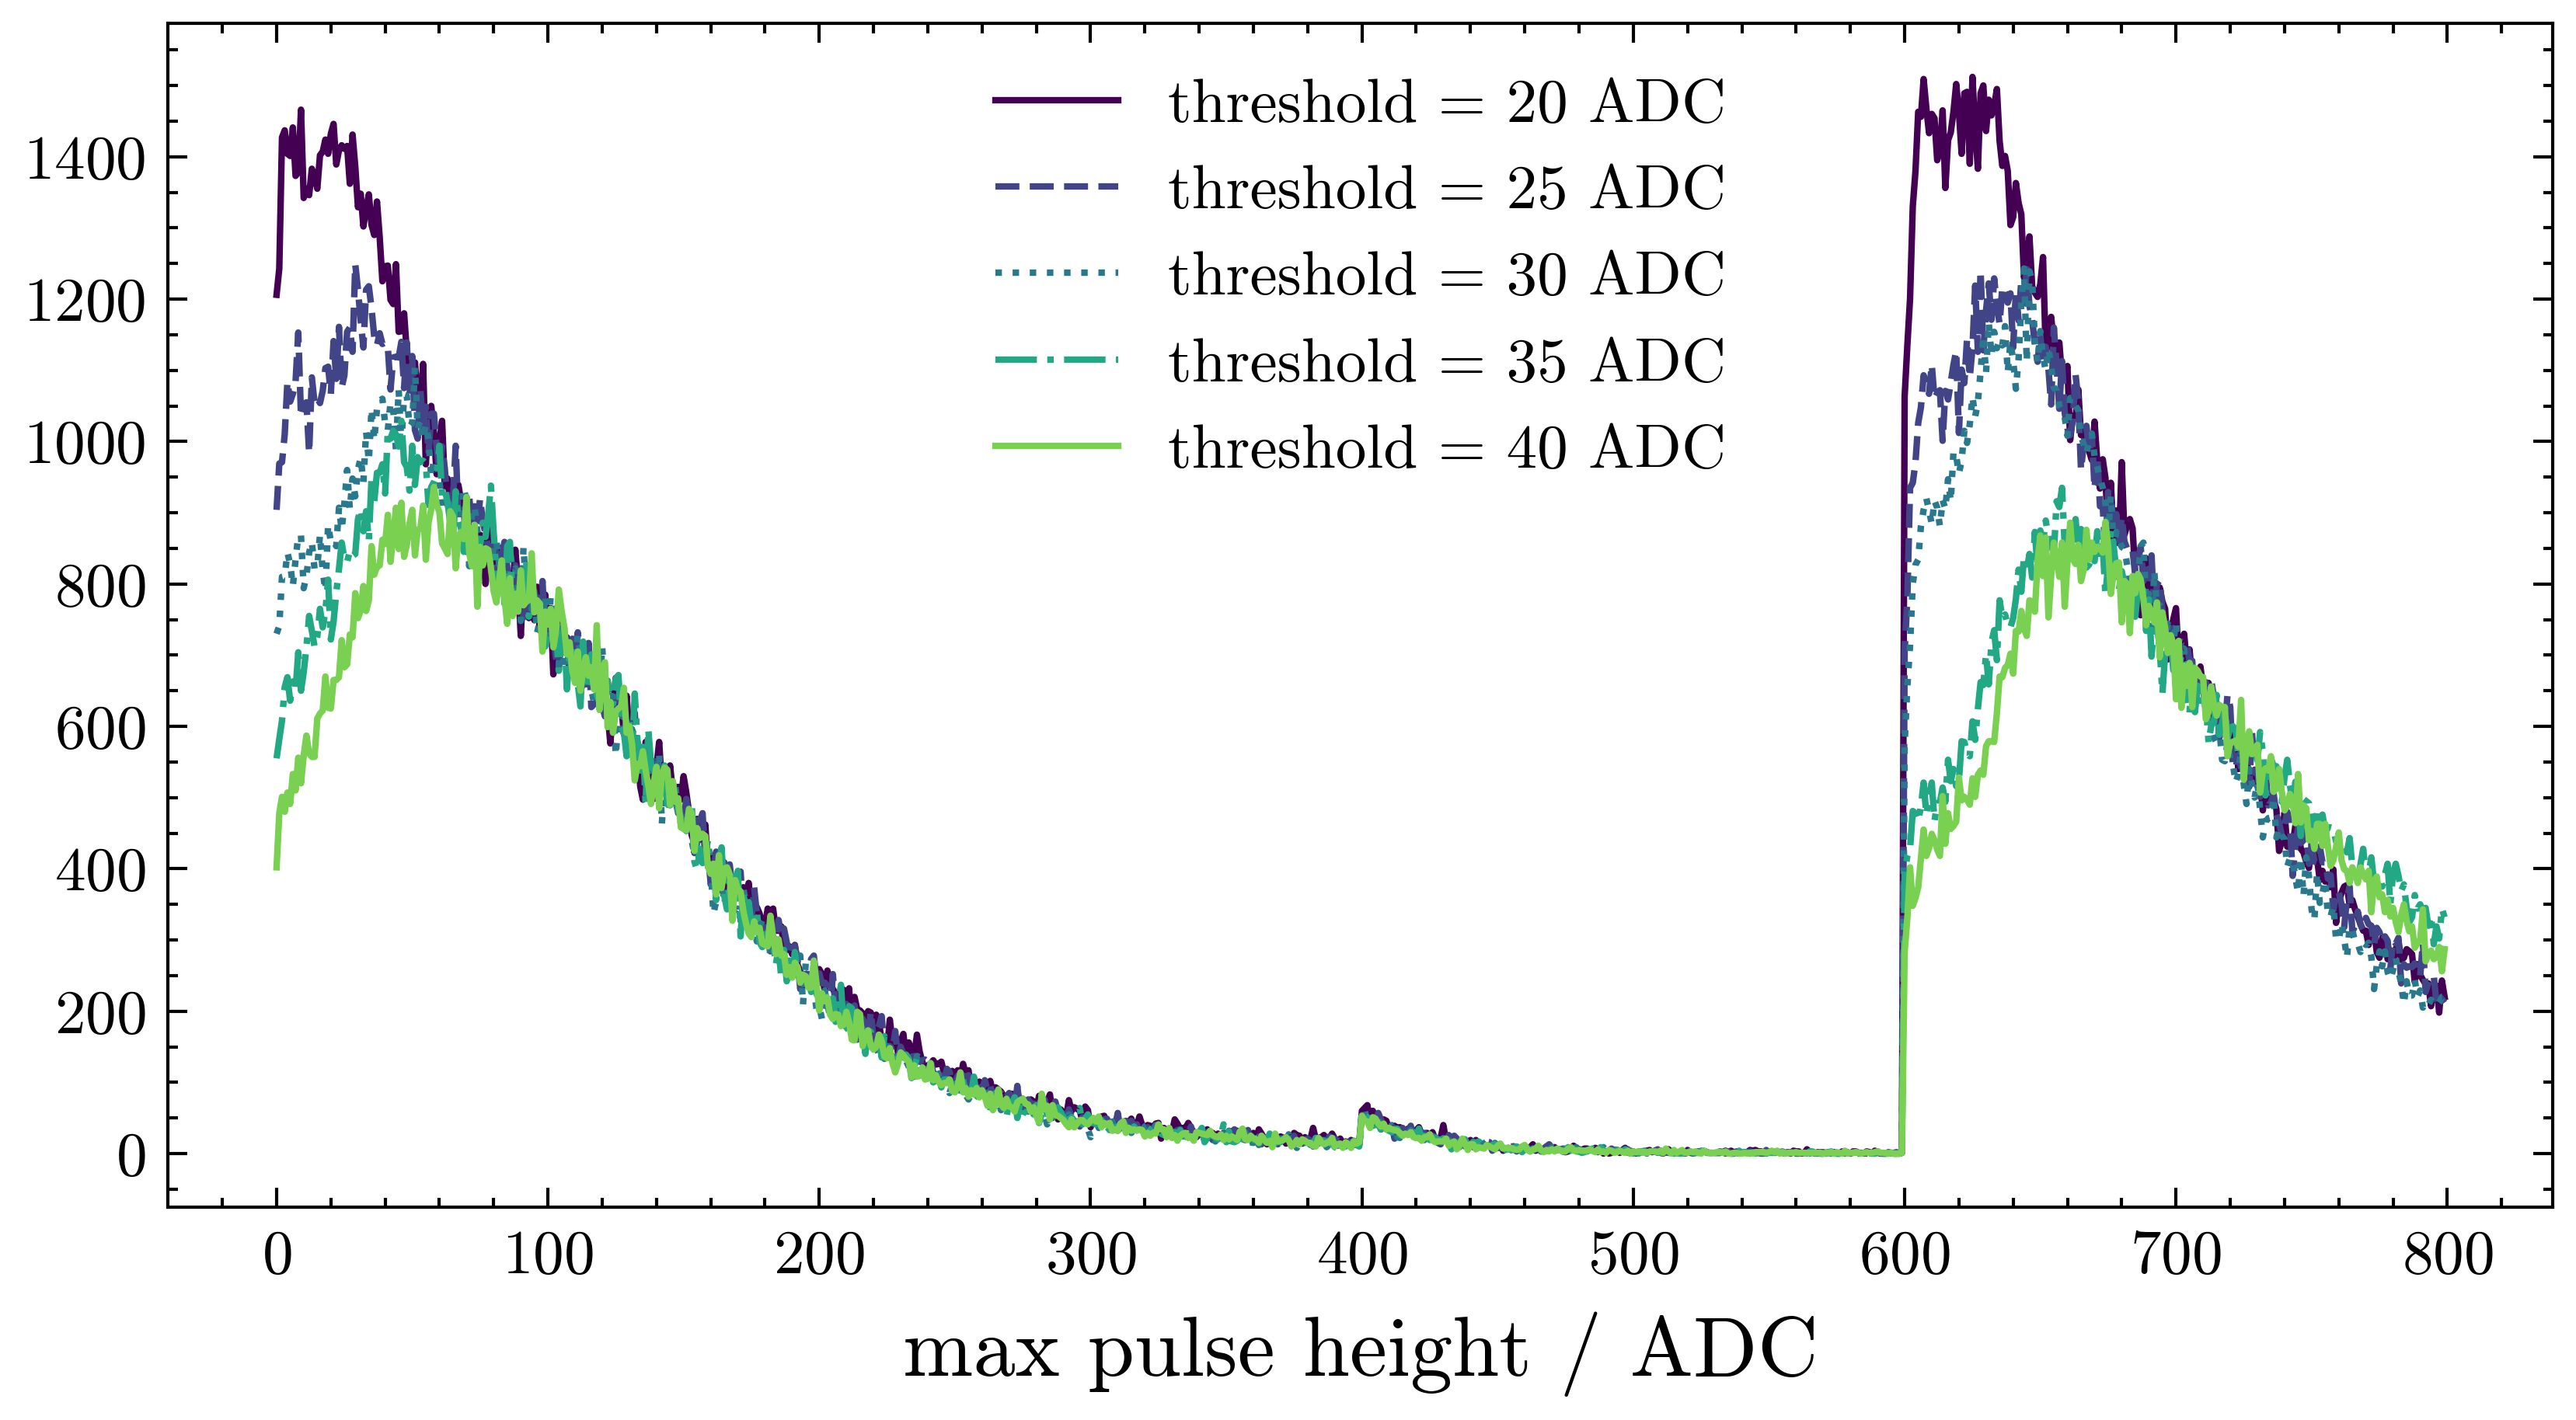

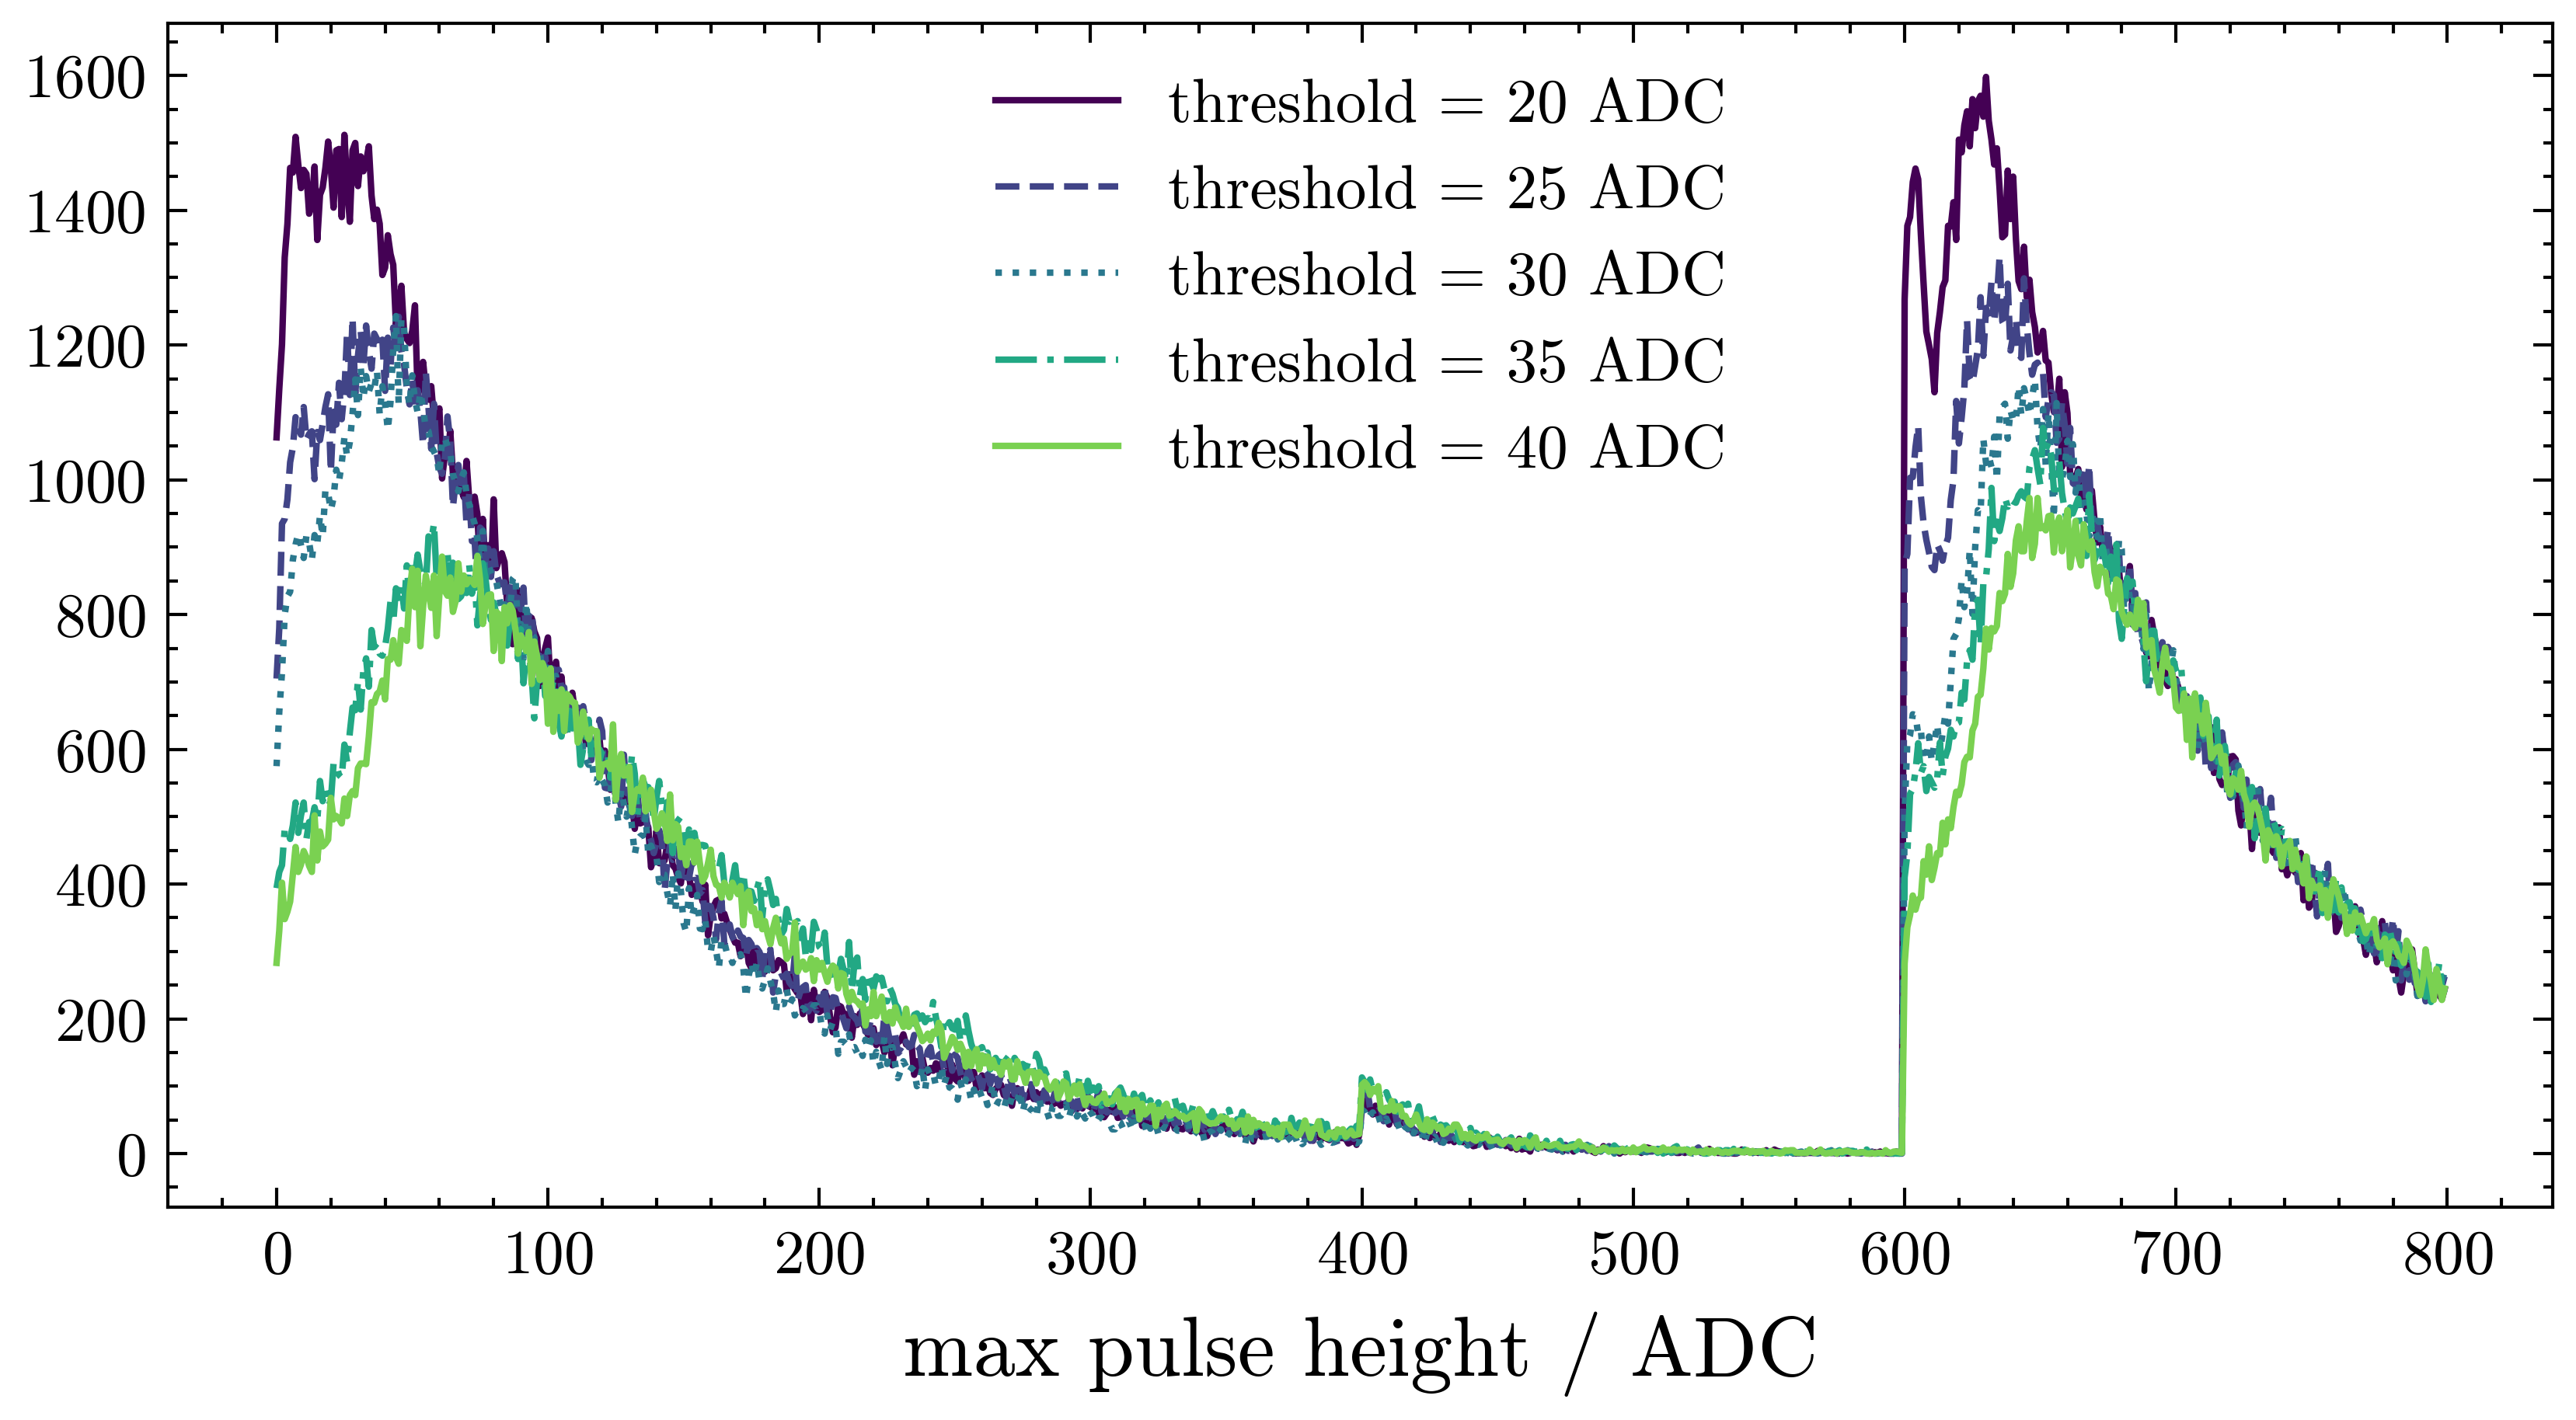

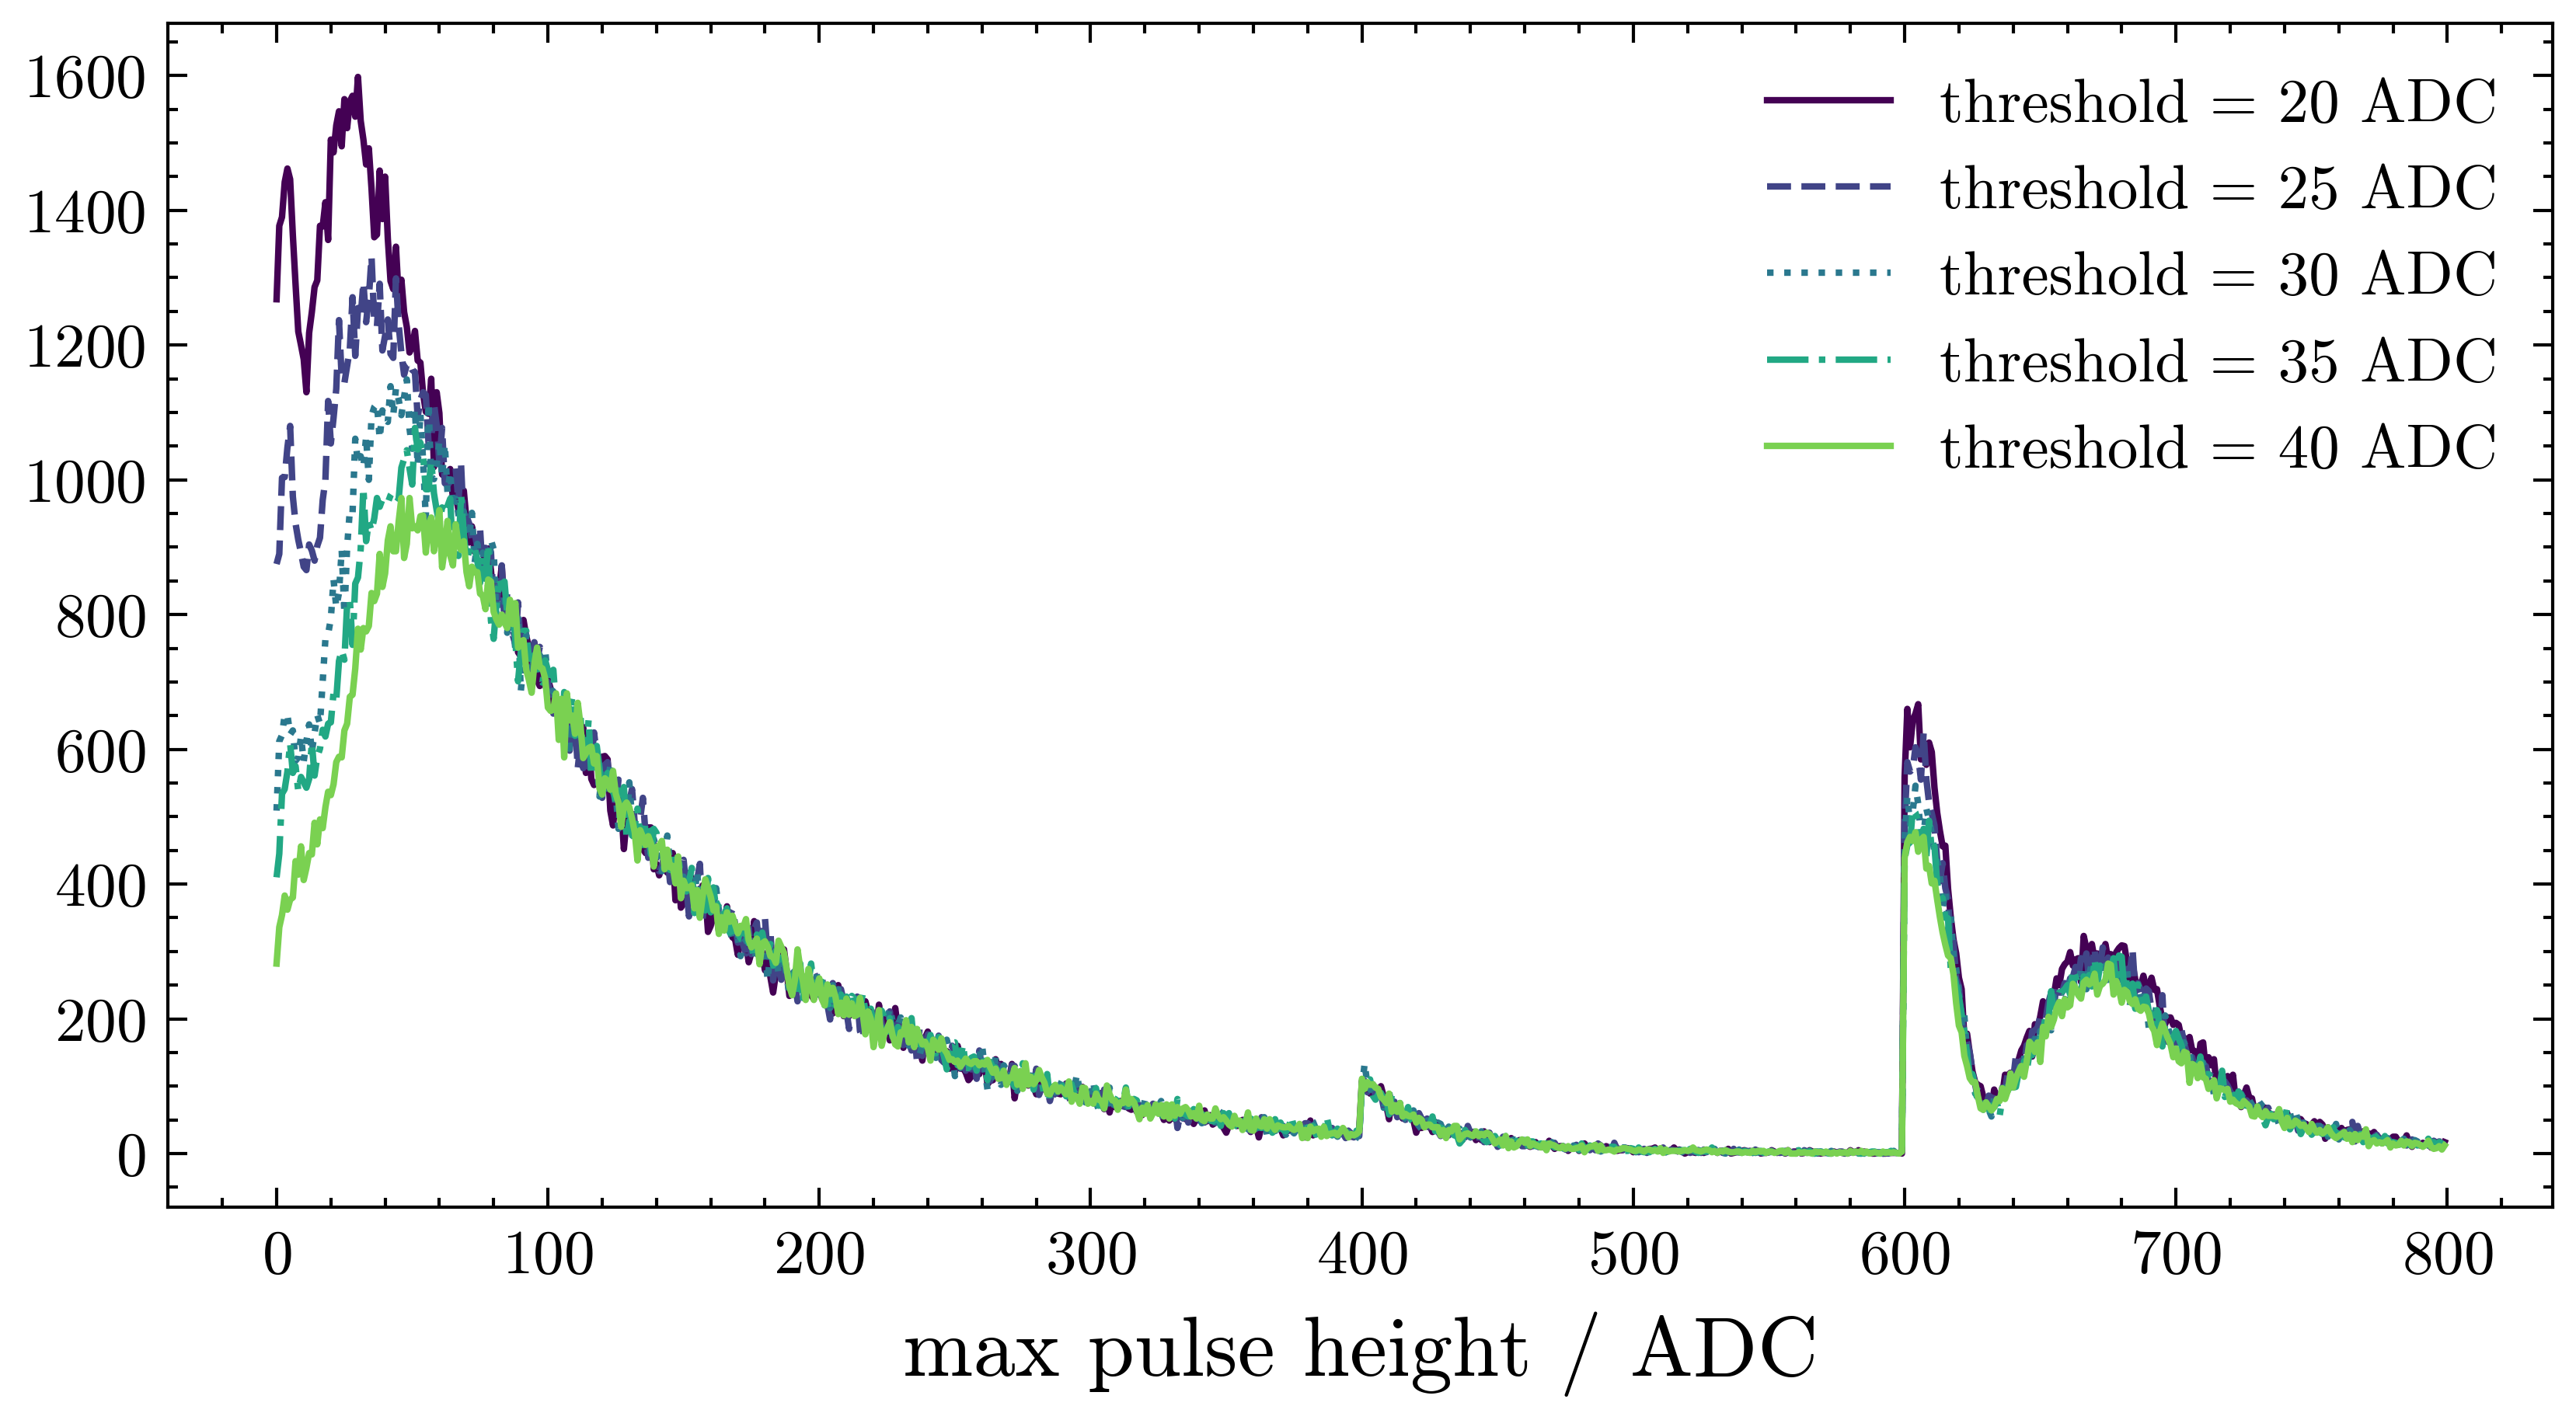

In [11]:
from utils.plotting import *
from utils import CONSTANTS

data = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v32/charge.txt')
data = np.split(data, 5)

axes = [plt.subplots()[1] for _ in range(3)]
colors = plot.gradient(plt.cm.viridis, 5)

for th, h, c in zip(thresholds, data, colors):
    for i, (pmt, ax) in enumerate(zip(h, axes)):
        ax.plot(range(len(pmt[4:])), pmt[4:], c=c, label=f'threshold = {th} ADC')


for ax in axes:
    ax.legend()
    ax.set_xlabel('max pulse height / ADC')
    